<a href="https://colab.research.google.com/github/Siphoz/dice-roller/blob/master/Deep_learning_All_Valves_Cost_Prediction_Updated_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Valves analysis

In [4]:
from os import path
# Data manipulation
import numpy as np
import pandas as pd
# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer


# VIEWING OPTIONS IN THE NOTEBOOK
from sklearn import set_config; set_config(display='diagram')

## Data Exploration

In [5]:
from google.colab import drive
drive.mount('/content/drive')

valves_path = '/content/drive/MyDrive/CESK 2022 - Objects European (Metric) ASME -Analysis2.xlsx'
AllValve_df = pd.read_excel(valves_path, sheet_name= 1, usecols="A:N", skiprows=0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
AllValve_df.head(3)


,Referential ID [Referential ID],Description [Description],Valve type,Connection,Material,Pound rating,Size,Size.1,Size_T,Original cost [Original Cost],Original currency [Currency *],Weight [Weight],Level ID [Level ID],ID [ID *]
0,UCC4040150050MC0IAD,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,SS316,300#,"D= 3"" / DN 80",80,NaN,3336.444929,EUR,38.68,Unit-Rates,L4KB13921938
1,UCC4040130050MB0IAC,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,SS316,150#,"D= 2 1/2"" / DN 65",65,NaN,4047.020180,EUR,17.31,Unit-Rates,L4KB13921941
2,UCC4040150050MC0BAD,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,LTCS,300#,"D= 3"" / DN 80",80,NaN,1909.444938,EUR,38.00,Unit-Rates,L4KB13921946


In [7]:
# Define a function to clean the key names
def clean_key_name(key_name):
    key_name = key_name.replace('150#', '150') \
                       .replace('300#', '300') \
                       .replace('500#', '500') \
                       .replace('600#', '600') \
                       .replace('900#', '900') \
                       .replace('1500#', '1500') \
                       .replace('2500#', '2500') \
                       .replace('3000#', '3000')
    return key_name

# Apply the cleaning function to the 'file_names' column
AllValve_df['Pound rating 2'] = AllValve_df['Pound rating'].apply(clean_key_name)

# Print the resulting DataFrame
AllValve_df


,Referential ID [Referential ID],Description [Description],Valve type,Connection,Material,Pound rating,Size,Size.1,Size_T,Original cost [Original Cost],Original currency [Currency *],Weight [Weight],Level ID [Level ID],ID [ID *],Pound rating 2
0,UCC4040150050MC0IAD,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,SS316,300#,"D= 3"" / DN 80",80,NaN,3336.444929,EUR,38.68,Unit-Rates,L4KB13921938,300
1,UCC4040130050MB0IAC,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,SS316,150#,"D= 2 1/2"" / DN 65",65,NaN,4047.020180,EUR,17.31,Unit-Rates,L4KB13921941,150
2,UCC4040150050MC0BAD,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,LTCS,300#,"D= 3"" / DN 80",80,NaN,1909.444938,EUR,38.00,Unit-Rates,L4KB13921946,300
3,UCC4040040050MC0HAD,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,SS304,300#,"D= 1/2"" / DN 15",15,NaN,1213.705631,EUR,5.04,Unit-Rates,L4KB13921956,300
4,UCC4040040050MB0HAC,"Piping, Material, Valve, Ball (Manual operated...",Ball,TRD,SS304,150#,"D= 1/2"" / DN 15",15,NaN,977.585321,EUR,5.04,Unit-Rates,L4KB13921958,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8543,NaN,"Piping, Material, Valve, Ball (Manual operated...",Ball,BW,Hasteloy,900#,"D= 12"" / DN 300",300,NaN,105000.000000,NaN,NaN,NaN,NaN,900
8544,NaN,"Piping, Material, Valve, Ball (Manual operated...",Ball,BW,Titanium,150#,"D= 12"" / DN 300",300,NaN,25000.000000,NaN,NaN,NaN,NaN,150
8545,NaN,"Piping, Material, Valve, Ball (Manual operated...",Ball,BW,Titanium,300#,"D= 12"" / DN 300",300,NaN,27500.000000,NaN,NaN,NaN,NaN,300
8546,NaN,"Piping, Material, Valve, Ball (Manual operated...",Ball,BW,Titanium,600#,"D= 12"" / DN 300",300,NaN,40500.000000,NaN,NaN,NaN,NaN,600


In [8]:
AllValve_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Referential ID [Referential ID]  8534 non-null   object 
 1   Description [Description]        8547 non-null   object 
 2   Valve type                       8548 non-null   object 
 3   Connection                       8548 non-null   object 
 4   Material                         8548 non-null   object 
 5   Pound rating                     8548 non-null   object 
 6   Size                             8548 non-null   object 
 7   Size.1                           8548 non-null   int64  
 8   Size_T                           0 non-null      float64
 9   Original cost [Original Cost]    8548 non-null   float64
 10  Original currency [Currency *]   8534 non-null   object 
 11  Weight [Weight]                  8349 non-null   float64
 12  Level ID [Level ID] 

In [9]:
# Convert the 'Pound Rating 2' column to integer using pd.to_numeric()
AllValve_df['Pound rating 2'] = pd.to_numeric(AllValve_df['Pound rating 2'])

In [10]:
AllValve_df.isnull().sum().sort_values(ascending=False).head(10)

,0
Size_T,8548
Weight [Weight],199
Referential ID [Referential ID],14
Original currency [Currency *],14
Level ID [Level ID],14
ID [ID *],14
Description [Description],1
Valve type,0
Connection,0
Material,0


In [11]:
AllValve_df.columns

Index(['Referential ID [Referential ID]', 'Description [Description]',
       'Valve type', 'Connection', 'Material', 'Pound rating', 'Size',
       'Size.1', 'Size_T', 'Original cost [Original Cost]',
       'Original currency [Currency *]', 'Weight [Weight]',
       'Level ID [Level ID]', 'ID [ID *]', 'Pound rating 2'],
      dtype='object')

In [12]:
df=AllValve_df.drop(['Referential ID [Referential ID]',
                          'Description [Description]',
                          'Size',
                          'Referential ID [Referential ID]',
                          'Size',
                          'Size_T',
                          'Level ID [Level ID]',
                          'ID [ID *]',
                          'Original currency [Currency *]',], axis=1)

In [13]:
df.head()

,Valve type,Connection,Material,Pound rating,Size.1,Original cost [Original Cost],Weight [Weight],Pound rating 2
0,Ball,TRD,SS316,300#,80,3336.444929,38.68,300
1,Ball,TRD,SS316,150#,65,4047.020180,17.31,150
2,Ball,TRD,LTCS,300#,80,1909.444938,38.00,300
3,Ball,TRD,SS304,300#,15,1213.705631,5.04,300
4,Ball,TRD,SS304,150#,15,977.585321,5.04,150


In [14]:
numeric_df = df.select_dtypes(include=['number'])


### Correlation analysis

<Axes: >

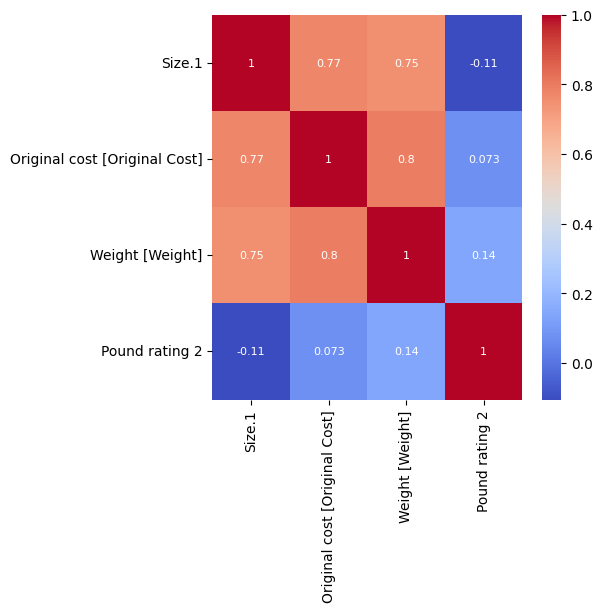

In [15]:
plt.figure(figsize = (5, 5))

sns.heatmap(
    numeric_df.corr(),
    cmap = 'coolwarm',
    annot = True,
    annot_kws = {"size": 8}
)

👉 `Costs` is mainly affected by the `Weight, Size, and Pound Rating` (In that order)

### Material vs Cost Scatter Diagram

## Building a Machine learning Cost model

In [16]:
df = df.drop(['Pound rating 2'], axis=1)

### Main DataFrame (Categorigal and Numerical features)

In [17]:
df.head()

,Valve type,Connection,Material,Pound rating,Size.1,Original cost [Original Cost],Weight [Weight]
0,Ball,TRD,SS316,300#,80,3336.444929,38.68
1,Ball,TRD,SS316,150#,65,4047.020180,17.31
2,Ball,TRD,LTCS,300#,80,1909.444938,38.00
3,Ball,TRD,SS304,300#,15,1213.705631,5.04
4,Ball,TRD,SS304,150#,15,977.585321,5.04


### Encode Categorical features

### Impute Missing Costs

In [18]:
# Drop rows with missing values
df = df.dropna()

In [19]:
df.tail(5)

,Valve type,Connection,Material,Pound rating,Size.1,Original cost [Original Cost],Weight [Weight]
8529,Globe,"Needle Type, Flanged RTJ",SS304,600#,125,21919.772532,242.85
8530,Globe,"Needle Type, Flanged RTJ",SS316,600#,65,10566.548844,74.31
8531,Globe,"Needle Type, Flanged RTJ",Duplex,600#,100,15659.101150,146.16
8532,Globe,"Needle Type, Flanged RTJ",SS316,300#,150,14610.345067,152.68
8533,Globe,"Needle Type, Flanged RTJ",SS304,1500#,100,16565.551357,437.78


### Split the dataset into Train and Test datasets

In [20]:
df.columns

Index(['Valve type', 'Connection', 'Material', 'Pound rating', 'Size.1',
       'Original cost [Original Cost]', 'Weight [Weight]'],
      dtype='object')

In [21]:
# Split the dataset into features (X) and target variable (y)
features = df.drop(['Original cost [Original Cost]'], axis=1)
target = df['Original cost [Original Cost]']

In [22]:
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [23]:
def create_preproc_ordinal():
    feat_ordinal_dict = {
        # considers "missing" as the worse category

    }

    feat_ordinal = sorted(feat_ordinal_dict.keys())
    feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

    encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        handle_unknown="use_encoded_value",
        unknown_value=-1  # Considers unknown values as worse than "missing"
    )

    preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        encoder_ordinal,
        MinMaxScaler()
    )

    return preproc_ordinal, feat_ordinal


def create_preproc_numerical():
    return make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

def create_preproc_nominal():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

def create_preproc(X, percentile = 75):
    """Create an (unfitted) sklearn preprocessing pipeline well suited for Prices estimation

    Args:
        X (pandas.DataFrame): Feature matrix
        percentile (float): Percentage of feature to keep after one hot encoding

    Returns:
        sklearn.pipeline.Pipeline: un-fitted preprocessor
    """
    preproc_ordinal, feat_ordinal = create_preproc_ordinal()

    preproc_numerical = create_preproc_numerical()
    feat_numerical = sorted(X.select_dtypes(
        include=["int64", "float64"]).columns)

    preproc_nominal = create_preproc_nominal()
    feat_nominal = sorted(
        list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical),
        ("ordinal_encoder", preproc_ordinal, feat_ordinal),
        ("nominal_encoder", preproc_nominal, feat_nominal)
        ],
        remainder="drop")

    feature_selector = SelectPercentile(
        mutual_info_regression,
        percentile=percentile,  # keep the xx% most important features
    )

    preproc = make_pipeline(
        feature_transformer,
        feature_selector
    )
    return preproc


In [24]:
preproc = create_preproc(X_train)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Size.1',
                                                   'Weight [Weight]']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=...
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  []),
                                                 ('nominal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Connection', 'Material',
                                                   'Pound rating',
                                                   'Valve type'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x7878064d2340>))])

In [25]:
y_train

,Original cost [Original Cost]
1351,851.061129
2117,2540.193664
5758,540.244997
2360,1459.790379
5697,40225.556346
...,...
5915,515.034064
5372,50053.058567
5571,15207.358439
1008,14836.792008


In [26]:
X_train

,Valve type,Connection,Material,Pound rating,Size.1,Weight [Weight]
1351,"Check, Swing",BW,LTCS,150#,65,22.00
2117,Globe,BW,CS,1500#,80,213.00
5758,Gate,Flanged RTJ,CS,2500#,25,60.00
2360,Ball,Flanged RF,Duplex,1500#,15,20.60
5697,Ball,Flanged RTJ,CS,150#,750,3600.00
...,...,...,...,...,...,...
5915,Gate,Flanged RTJ,SS316,600#,15,6.11
5372,Ball,Flanged RTJ,CS,1500#,450,3100.00
5571,Ball,Flanged RTJ,SS304,300#,250,367.33
1008,Ball,BW,Duplex,900#,125,170.28


In [27]:
X_train.isnull().sum().sort_values(ascending=False).head(10)

,0
Valve type,0
Connection,0
Material,0
Pound rating,0
Size.1,0
Weight [Weight],0


In [28]:
# Fit the preprocessor on the train set
preproc.fit(X_train, y_train)

# Create the preprocessed versions of X_train and X_test
X_train_preproc = preproc.transform(X_train)
X_test_preproc = preproc.transform(X_test)

# Let's also already create the preprocessed version of X_test for our future predictions
# X_test_preproc = preproc.transform(X_test)

In [29]:
# Shapes before preprocessing
X_train.shape, X_test.shape, X_test.shape

((6679, 6), (1670, 6), (1670, 6))

In [30]:
# Shapes after preprocessing
X_train_preproc.shape, X_test_preproc.shape

((6679, 21), (1670, 21))

In [31]:
X_train_preproc

<6679x21 sparse matrix of type '<class 'numpy.float64'>'
	with 34785 stored elements in Compressed Sparse Row format>

In [32]:
from tensorflow.keras import Sequential, layers

def initialize_model(X):

    #################################
    #  1 - Model architecture       #
    #################################

    model = Sequential()

    # Input Layer
    model.add(layers.Dense(20, activation='relu', input_dim = X.shape[-1]))

    # Hidden Layers
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))

    # Predictive Layer
    model.add(layers.Dense(1, activation='linear'))

    ##################################
    #  2 - Our recommended compiler  #
    ##################################

    model.compile(optimizer='adam',
                  loss='msle')      # directly optimize for the squared log error!

    return model

In [33]:
import tensorflow as tf

# Convert X_train_preproc and X_test_preproc to SparseTensors
X_train_preproc_sparse = tf.sparse.SparseTensor(
    indices=np.column_stack(X_train_preproc.nonzero()),
    values=X_train_preproc.data,
    dense_shape=X_train_preproc.shape
)

X_test_preproc_sparse = tf.sparse.SparseTensor(
    indices=np.column_stack(X_test_preproc.nonzero()),
    values=X_test_preproc.data,
    dense_shape=X_test_preproc.shape
)

# Convert y_train to a Numpy array
y_train_array = np.array(y_train)

# Convert SparseTensors to dense tensors
X_train_preproc_dense = tf.sparse.to_dense(X_train_preproc_sparse)
X_test_preproc_dense = tf.sparse.to_dense(X_test_preproc_sparse)

# 1. Initializing a NeuralNet with its architecture and its compilation method
model = initialize_model(X_train_preproc_dense)
model.summary()

# 2. Training the model
epochs = 500
batch_size = 16

history = model.fit(X_train_preproc_dense,
                    y_train_array,  # Use the Numpy array version of y_train
                    validation_data=(X_test_preproc_dense, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0)

# 3. Evaluating the model
res = model.evaluate(X_test_preproc_dense, y_test, verbose=0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5, 3)}")

# 4. Looking at the lowest loss
minimum_rmlse_val = min(history.history['val_loss']) ** 0.5
optimal_momentum = np.argmin(history.history['val_loss'])

print(f"Lowest RMLSE achieved = {round(minimum_rmlse_val, 3)}")
print(f"This was achieved at the epoch number {optimal_momentum}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,336 (5.22 KB)

 Trainable params: 1,336 (5.22 KB)

 Non-trainable params: 0 (0.00 B)

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

In [ ]:
plot_history(history)

### Make Predictions

In [ ]:
sample_data = pd.read_excel(valves_path, sheet_name= 2, usecols="A:N", skiprows=0)


In [ ]:
sample_data.head()

In [ ]:
sample_data=sample_data.drop(['Referential ID [Referential ID]',
                          'Description [Description]',
                          'Size',
                          'Referential ID [Referential ID]',
                          'Size',
                          'Original cost [Original Cost]',
                          'Level ID [Level ID]',
                          'ID [ID *]',
                          'Original currency [Currency *]',], axis=1)

In [ ]:
sample_data.head()

In [ ]:
X_pred = sample_data
X_pred_preproc = preproc.transform(X_pred)


In [ ]:
X_pred_preproc

In [ ]:
predictions = model.predict(X_pred_preproc)
predictions

In [ ]:
results = pd.concat([
                        X_pred["Valve type"],
                        pd.Series(predictions[:,0], name="Price")
                    ],
                    axis=1)
results

In [ ]:
# Predicted cost values
X_pred['Predicted_Costs'] = model.predict(X_pred_preproc)

In [ ]:
X_pred.head(50)

### Import to excel

In [ ]:
# Specify the file path and name for the Excel file
file_path = "Predicted_Costs_Deep_NEW.xlsx"

# Save the DataFrame to an Excel file
X_pred.to_excel(file_path, index=False)

print("DataFrame saved to Excel successfully.")

